In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import pysentani as sti
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')
survey['access_type'] = sti.access_type(survey)

Up to this point we have strictly been using point estimates for electricity use to comapare to the five villages that we have metered data on. A more appropriate method would be to provide a range of estimates idealy from a distribution. 

The next two cells are the calculations we have been using to estimate energy from use frequency and power levels.

In [2]:
for app in ['TV', 'radio', 'fridge', 'fan', 'rice_cooker', 'lighting']:
    # generate column labels for each appliance
    wk_col = 'app_{}_per_wk'.format(app)
    hr_col = 'app_{}_hrs'.format(app)
    # if null or within range use value, otherwise use max possible value
    survey[hr_col] = survey[hr_col].where(survey[hr_col].isnull() | (survey[hr_col] <= 24), 24)
    survey[wk_col] = survey[wk_col].where(survey[wk_col].isnull() | (survey[wk_col] <= 7), 7)

    # ensure non-null values are within bounds
    assert(all(survey[wk_col].dropna() <= 7))
    assert(all(survey[wk_col].dropna() >= 0))
    assert(all(survey[hr_col].dropna() <= 24))
    assert(all(survey[hr_col].dropna() >= 0))

In [3]:
powers = {'TV':0.040, 'fridge':0.100, 'radio':0.010, 'fan':0.050, 'rice_cooker':0.350, 'lighting':0.050}
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]

I want to create a dataframe consisting of newly derived energy columns and village name which will be filtered down to the five villages of interest later in this analysis.

In [4]:
columns = ['village_name','daily_lighting_energy','daily_TV_energy','daily_radio_energy', 
           'daily_fridge_energy', 'daily_rice_cooker_energy','daily_fan_energy']

I create a total daily energy column by suming across all columns (`.sum(axis=1`) of daily appliance energy calculations. Null results are still present in the data and exist if respondents did not indicate use frequency for a given appliance. Null results are given a value of `0` which provides an accurate representation of village electriciy use when calculating mean.

In [5]:
survey['total_daily_energy'] = survey[columns].sum(axis=1)
survey['total_daily_energy'] = survey['total_daily_energy'].fillna(0)
village_daily_energy = survey[['total_daily_energy','village_name']]
village_daily_energy.head()

,total_daily_energy,village_name
0,0.180000,Puai
1,0.131429,Abar
2,0.120000,Abar
3,0.137143,Abar
4,0.300000,Abar


I create a new dataframe by selecting the five villages of interest within the `'village_name'` column.

In [6]:
interest_villages =  village_daily_energy[village_daily_energy['village_name'].str.contains('Asei|Ajau|Atamali|Ayapo|Kensio')]
interest_villages.head()

,total_daily_energy,village_name
34,0.182857,Kensio
35,0.348571,Kensio
46,1.810000,Asei
47,3.630000,Asei
48,4.640000,Asei


The data is plotted with a seaborn facetgrid which displays a histogram of household electricity calculations in each village.

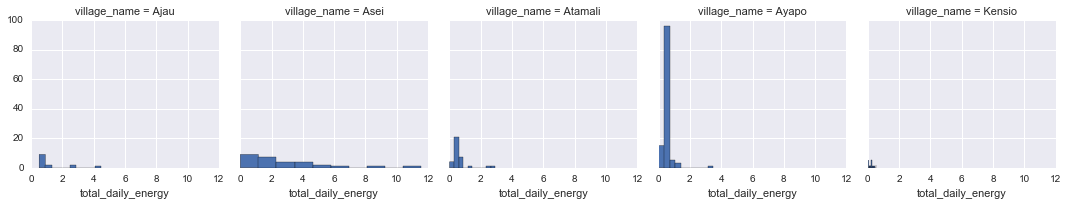

In [7]:
g = sns.FacetGrid(interest_villages, col='village_name',col_order = ['Ajau','Asei','Atamali','Ayapo','Kensio'])
g.map(plt.hist, 'total_daily_energy')

The mean is taken in each village to ensure that the data is the same as calculated in previous analysis.

In [8]:
interest_villages.groupby('village_name').mean()

,total_daily_energy
village_name,
Ajau,1.249592
Asei,2.637685
Atamali,0.626163
Ayapo,0.495869
Kensio,0.201654


We will also plot the distribution curve for each village to get a better idea of the data.

### Asei Household Electricity Use Distribution

In [9]:
ajau =  village_daily_energy[village_daily_energy['village_name'].str.contains('Ajau')]
ajau.head()

,total_daily_energy,village_name
348,0.514286,Ajau
349,4.485714,Ajau
350,2.588571,Ajau
351,0.514286,Ajau
352,0.600000,Ajau


/Users/Matt/miniconda3/envs/mrenv/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


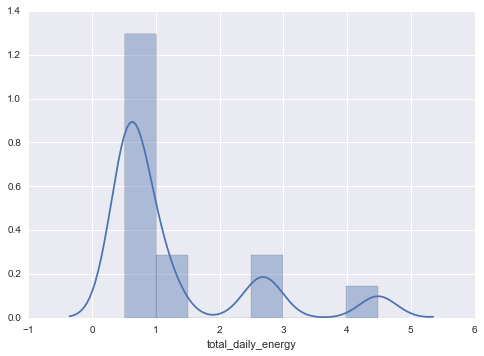

In [10]:
sns.distplot(ajau['total_daily_energy'])

### Asei Household Electricity Use Distribution

/Users/Matt/miniconda3/envs/mrenv/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


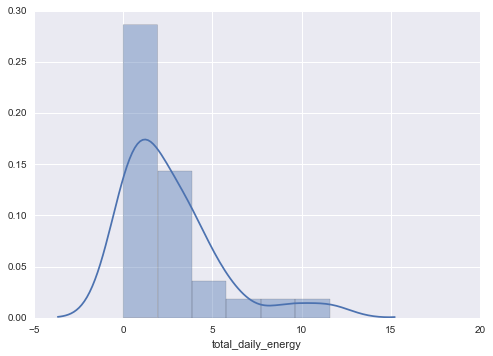

In [11]:
asei =  village_daily_energy[village_daily_energy['village_name'].str.contains('Asei')]
sns.distplot(asei['total_daily_energy'])

### Atamali Household Electricity Use Distribution

/Users/Matt/miniconda3/envs/mrenv/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


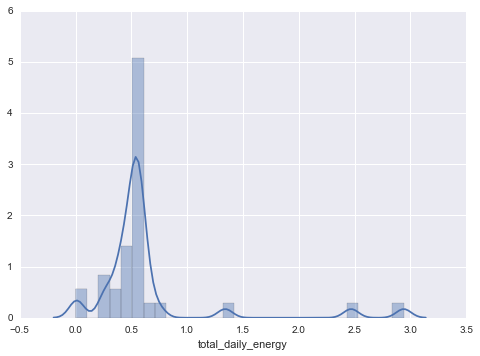

In [12]:
atamali =  village_daily_energy[village_daily_energy['village_name'].str.contains('Atamali')]
sns.distplot(atamali['total_daily_energy'])

### Ayapo Household Electricity Use Distribution

/Users/Matt/miniconda3/envs/mrenv/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


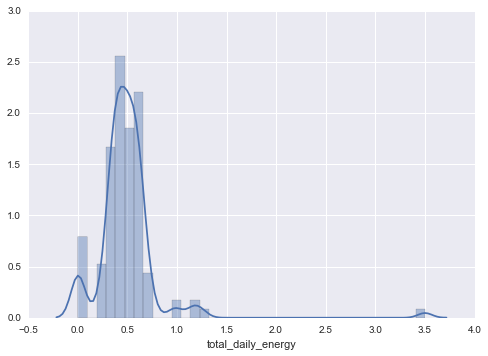

In [13]:
ayapo =  village_daily_energy[village_daily_energy['village_name'].str.contains('Ayapo')]
sns.distplot(ayapo['total_daily_energy'])

### Ajau Household Electricity Use Distribution

/Users/Matt/miniconda3/envs/mrenv/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


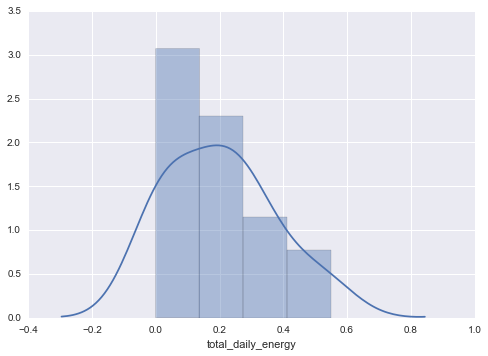

In [14]:
kensio =  village_daily_energy[village_daily_energy['village_name'].str.contains('Kensio')]
sns.distplot(kensio['total_daily_energy'])

### Next Steps: Now that we have a more clear picture of how the data is distributed by household we need to quantify the distribution mathematically. I need to figure out which distribution curve is most appropriate to use for each village. Some of the villages appear to be normally distributed while others are quite irregular.